This notebook contains a step-by-step guide for fine-tuning `gpt-3.5-turbo` model. We will use the Titanic dataset for this tutorial. We will first build a (simple) classification model using the target label `survived`. Then we will use Shapley analysis to identify features that contributed to each passenger's survival estimate. The ouput from Shapley analysis will then be used to fine-tune an LLM model. We would like to fine-tune a GPT model in such a way that when we provide the output data points from the Shapley analysis to the LLM model, it should be able to generate a summary in plain English that explains why the passenger did or did not survive. 

Here are the steps we will follow:

1. Read the Titanic dataset and prepare the data for modeling.
2. Build a simple classification model.
3. Perform Shapley analysis to identify the top contributors for each passanger.
4. Prepare training data for fine-tuning a GPT model (by converting Shapley output into plain English).
5. Fine-tune `gpt-3.5-turbo` using the training data prepared in the previous step.
6. Make inference on a new passenger (not in the training data) to make sure that the fine-tuned model is working as expected.
7. Build a Gradio UI where a user can choose a passanger and view the results.

This notebook is organized into three sections: 1. Classification Model, 2. Shapley Analysis, and 3. Fine-tuning.

### Import packages

In [71]:
# data processing
import pandas as pd
import numpy as np
# modeling
from sklearn.ensemble import RandomForestClassifier
import joblib
# shapley analysis
import shap
# utilities
from pprint import pprint
import json
import os
import sys
# gradio UI
import gradio as gr
import matplotlib.pyplot as plt
import tempfile
# openai
from openai import OpenAI
from dotenv import find_dotenv, load_dotenv

### Read the dataset

In [2]:
df = pd.read_csv('../data/titanic.csv', index_col='Name')

# let's drop unnecessary columns and rename a few
df = df.drop(columns=['PassengerId', 'Ticket'])\
    .rename(columns={'Pclass': 'Ticket Class', 'Parch': 'Family Members', 'SibSp': 'Siblings'})

# convert the ticket class from numeric to string
classes = {1: 'Upper', 2: 'Middle', 3: 'Lower'}
df['Ticket Class'] = df['Ticket Class'].map(classes)

# number of people the passenger was traveling with (0 if traveling alone)
df['Family Members'] = 1 + df['Family Members']

# change the column type to categorical 
cat_cols = ['Ticket Class', 'Sex', 'Embarked']

for cat_col in cat_cols:
    df[cat_col] = df[cat_col].astype('category')

# make values for `embarked` more interpretable 
ports = {'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'}
df['Embarked'] = df['Embarked'].map(ports)

df.head(5)

,Survived,Ticket Class,Sex,Age,Siblings,Family Members,Fare,Cabin,Embarked
Name,,,,,,,,,
"Braund, Mr. Owen Harris",0,Lower,male,22.0,1,1,7.2500,NaN,Southampton
"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",1,Upper,female,38.0,1,1,71.2833,C85,Cherbourg
"Heikkinen, Miss. Laina",1,Lower,female,26.0,0,1,7.9250,NaN,Southampton
"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,Upper,female,35.0,1,1,53.1000,C123,Southampton
"Allen, Mr. William Henry",0,Lower,male,35.0,0,1,8.0500,NaN,Southampton
"Moran, Mr. James",0,Lower,male,NaN,0,1,8.4583,NaN,Queenstown
"McCarthy, Mr. Timothy J",0,Upper,male,54.0,0,1,51.8625,E46,Southampton
"Palsson, Master. Gosta Leonard",0,Lower,male,2.0,3,2,21.0750,NaN,Southampton
"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,Lower,female,27.0,0,3,11.1333,NaN,Southampton


Are Cabin and Pclass the same thing?

In [3]:
cabin_assigned = pd.isnull(df['Cabin'])

pd.crosstab(cabin_assigned, df['Ticket Class'])

Ticket Class,Lower,Middle,Upper
Cabin,,,
False,12,16,176
True,479,168,40


No. So we should use `Cabin`. Let's use a binary flag for cabin-assigned, and drop `Cabin`.

In [4]:
df['Cabin'] = df['Cabin'].isna()
df['Cabin'].value_counts(dropna=False)

Cabin
True     687
False    204
Name: count, dtype: int64

Let's create dummies for the rest of the categorical features.

In [5]:
df_dummies = pd.get_dummies(df[cat_cols], drop_first=True)

df = df_dummies.merge(df.drop(columns=cat_cols), left_index=True, right_index=True)

# convert underscores to colons to improve legibility
df.columns = [x.replace('_', ': ') for x in df.columns]

df.head(2)

,Ticket Class: Middle,Ticket Class: Upper,Sex: male,Embarked: Queenstown,Embarked: Southampton,Survived,Age,Siblings,Family Members,Fare,Cabin
Name,,,,,,,,,,,
"Braund, Mr. Owen Harris",False,False,True,False,True,0,22.0,1,1,7.2500,True
"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",False,True,False,False,False,1,38.0,1,1,71.2833,False
"Heikkinen, Miss. Laina",False,False,False,False,True,1,26.0,0,1,7.9250,True
"Futrelle, Mrs. Jacques Heath (Lily May Peel)",False,True,False,False,True,1,35.0,1,1,53.1000,False
"Allen, Mr. William Henry",False,False,True,False,True,0,35.0,0,1,8.0500,True


Are there any missing values?

In [6]:
miss_ct = df.isnull().sum()
miss_ct[miss_ct != 0]

Age    177
dtype: int64

`Age` has some missing values; let's just replace them with median values.

In [7]:
df['age_missing'] = df['Age'].isna()
df['Age'] = df['Age'].fillna(df['Age'].median())
df.isnull().sum()

Ticket Class: Middle     0
Ticket Class: Upper      0
Sex: male                0
Embarked: Queenstown     0
Embarked: Southampton    0
Survived                 0
Age                      0
Siblings                 0
Family Members           0
Fare                     0
Cabin                    0
age_missing              0
dtype: int64

No more missing values!

### Build a model

Since the goal of this exercise is not to build the best model, but focus on how we can fine-tune a GPT model, we will simply train the (classification) model on the entire dataset.

In [8]:
y = df['Survived']
X = df.drop(columns=['Survived'])

X.shape, y.shape

((891, 11), (891,))

Let's skip hyper-parameter optimization and use cherry-picked values instead.

In [ ]:
clf = RandomForestClassifier(n_estimators=100, min_samples_split=0.03, random_state=314)
clf.fit(X, y)

Save the model.

In [ ]:
joblib.dump(clf, '../models/titanic_model_v1.json')

['../models/titanic_model_v1.json']

### Shapley analysis

I assume that you are familiar with Shapley analysis. If not, please refer to [An introduction to explainable AI with Shapley values](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).

In [10]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X)

Let's take a random passanger.

In [11]:
random_index = np.random.randint(0, len(X))
print(random_index)

578


In [12]:
random_index = 526 # note: the index number is different than above cuz I ran this multiple times

In [13]:
random_person = X.iloc[random_index]
surv = 'did not Survive' if y.iloc[random_index] == 0 else 'survived' 
surv

'survived'

Let's grab the Shapley values for this passanger and view the waterfall chart.

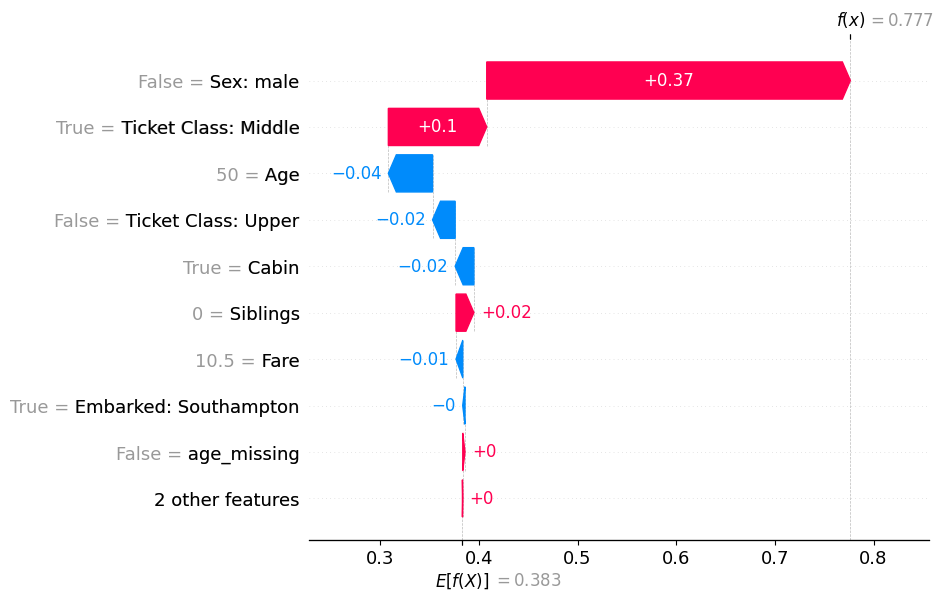

In [14]:
_shap_values = shap_values[random_index, :, 1]
shap.plots.waterfall(_shap_values)

This chart suggests that the biggest contributor to this passenger's unfortunate demise was the fact that he was a male. There are some smaller factors that improved his chances a little (such as age and Cabin), but overall those positive factors were not large enough to offset the negative contributions from age and ticket class (Middle).

We will grab overall means for all features and append them to the Shapley dataset.

In [15]:
all_means = pd.DataFrame(X.mean())
all_means.columns = ['overall_avg']

all_means['value'] = random_person.values
all_means.head()

,overall_avg,value
Ticket Class: Middle,0.206510,True
Ticket Class: Upper,0.242424,False
Sex: male,0.647587,False
Embarked: Queenstown,0.086420,False
Embarked: Southampton,0.722783,True


Create a consolidated Shapley dataset with all Shapley values and the overall means.

In [16]:
df_shap = pd.DataFrame(_shap_values.values, index=X.columns)
df_shap.columns = ['contribution']

df_shap = df_shap.merge(all_means, left_index=True, right_index=True)\
    .sort_values('contribution', ascending=False)

df_shap.head()

,contribution,overall_avg,value
Sex: male,0.368614,0.647587,False
Ticket Class: Middle,0.099736,0.206510,True
Siblings,0.018092,0.523008,0
age_missing,0.002236,0.198653,False
Family Members,0.000879,1.381594,1


### Prepare data for LLM

#### Sample 1

Now we need to create some explanations based on the Shapley output. These explanations will become part of the data that will be used to fine-tune a GPT model. 

But first let's organize the Shapley output into text format. For simplicity (and to save some time), let's just use the top three contributors from the Shapley output and create convert that tabular data into plain text format.

In [117]:
top_n = 3

In [17]:
sample_1 = ''

for i, row in df_shap.head(top_n).iterrows():
    if i == 'Fare':
        sample_1 += f"Feature --> {i} = ${row['value']:.0f}, Contribution: {row['contribution']:.1%}, "
    elif row['value'] in [True, False, 1, 0]:
        sample_1 += f"Feature --> {i} = {row['value']}, Contribution: {row['contribution']:.1%}, "
    else:
        sample_1 += f"Feature --> {i} = {row['value']:.1%}, Contribution: {row['contribution']:.1%}, "
    
    if row['value'] in [True, False, 1, 0]:
        sample_1 += f"Overall Average: {row['overall_avg']:.1%}\n"
    else:
        if i == 'Fare':
            sample_1 += f"Overall Average: ${row['overall_avg']:.1f}\n"
        else:
            sample_1 += f"Overall Average: {row['overall_avg']:.1f}\n"

pprint(sample_1)

('Feature --> Sex: male = False, Contribution: 36.9%, Overall Average: 64.8%\n'
 'Feature --> Ticket Class: Middle = True, Contribution: 10.0%, Overall '
 'Average: 20.7%\n'
 'Feature --> Siblings = 0, Contribution: 1.8%, Overall Average: 52.3%\n')


We will also append the outcome, aka whether the passanger survived the Titanic crash or not.

In [18]:
sample_1 += f'\nOutcome: This passenger {surv}.\n\n'
pprint(sample_1)

('Feature --> Sex: male = False, Contribution: 36.9%, Overall Average: 64.8%\n'
 'Feature --> Ticket Class: Middle = True, Contribution: 10.0%, Overall '
 'Average: 20.7%\n'
 'Feature --> Siblings = 0, Contribution: 1.8%, Overall Average: 52.3%\n'
 '\n'
 'Outcome: This passenger survived.\n'
 '\n')


Based on these data points, let's manually generate some explanation for why this passager survived.

In [19]:
explanation_1 = "The largest positive contributor to why this passanger survived was her gender. The fact that this passanger was a female improved her survival by as much as 36.6%. The second largest contributor was her ticket class: 'Middle', which improved her chances of survival by 10.0%. She was among the 20.7% of all passengers who were in the 'Middle' ticket class. Unlike the majority of the passengers (52.3%), she did not have any siblings, which improved her survival changes just slightly by 1.8%."

OpenAI fine-tuning API requires at least ten samples, so we will have to do this nine more time. Let's create a function.

If you are just reading through this notebook, and would like to skip over the other nine examples, skip directly to [Prepare LLM Prompt](#llm-prompt) section.

In [20]:
def get_sample(i=None, plot=True):
    if i == None:
        random_index = np.random.randint(0, len(X))
        print(random_index)
    else:
        random_index = i
        
    random_person = X.iloc[random_index]
    surv = 'did not Survive' if y.iloc[random_index] == 0 else 'survived' 

    _shap_values = shap_values[random_index, :, 1]
    if plot == True:
        shap.plots.waterfall(_shap_values)

    all_means['value'] = random_person.values

    df_shap = pd.DataFrame(_shap_values.values, index=X.columns)
    df_shap.columns = ['contribution']
    df_shap['abs_contribution'] = abs(df_shap['contribution'])
    df_shap = df_shap.merge(all_means, left_index=True, right_index=True)
    df_shap = df_shap.sort_values(by='abs_contribution', ascending=False)
    print(df_shap.head(3))

    _sample = ''

    for i, row in df_shap.head(3).iterrows():
        if i == 'Fare':
            _sample += f"Feature --> {i} = ${row['value']:.0f}, Contribution: {row['contribution']:.1%}, "
        elif (row['value'] in [True, False, 1, 0]) | (i == 'Siblings'):
            _sample += f"Feature --> {i} = {row['value']}, Contribution: {row['contribution']:.1%}, "
        else:
            _sample += f"Feature --> {i} = {row['value']:.1%}, Contribution: {row['contribution']:.1%}, "
        
        if row['value'] in [True, False, 1, 0]:
            _sample += f"Overall Average: {row['overall_avg']:.1%}\n"
        else:
            if i == 'Fare':
                _sample += f"Overall Average: ${row['overall_avg']:.1f}\n"
            else:
                _sample += f"Overall Average: {row['overall_avg']:.1f}\n"
    
    _sample += f'\nOutcome: This passenger {surv}.\n\n'

    return _sample

We will use this function to create nine more sample data points.

#### Sample 2

In [21]:
sample_2 = get_sample(800, False)

                     contribution  abs_contribution  overall_avg  value
Sex: male               -0.200476          0.200476     0.647587   True
Cabin                   -0.036367          0.036367     0.771044   True
Ticket Class: Upper     -0.024778          0.024778     0.242424  False


In [22]:
explanation_2 = "Unfortunately, this passenger did not survive, mainly driven by the fact that he was a male, which reduced his chance of survival by -20.0%. He stayed in a Cabin, and his ticket class was 'Upper', which further reduced his changes by -3.6% and -2.5% respectively."

In [23]:
pprint(sample_2)

('Feature --> Sex: male = True, Contribution: -20.0%, Overall Average: 64.8%\n'
 'Feature --> Cabin = True, Contribution: -3.6%, Overall Average: 77.1%\n'
 'Feature --> Ticket Class: Upper = False, Contribution: -2.5%, Overall '
 'Average: 24.2%\n'
 '\n'
 'Outcome: This passenger did not Survive.\n'
 '\n')


#### Sample 3

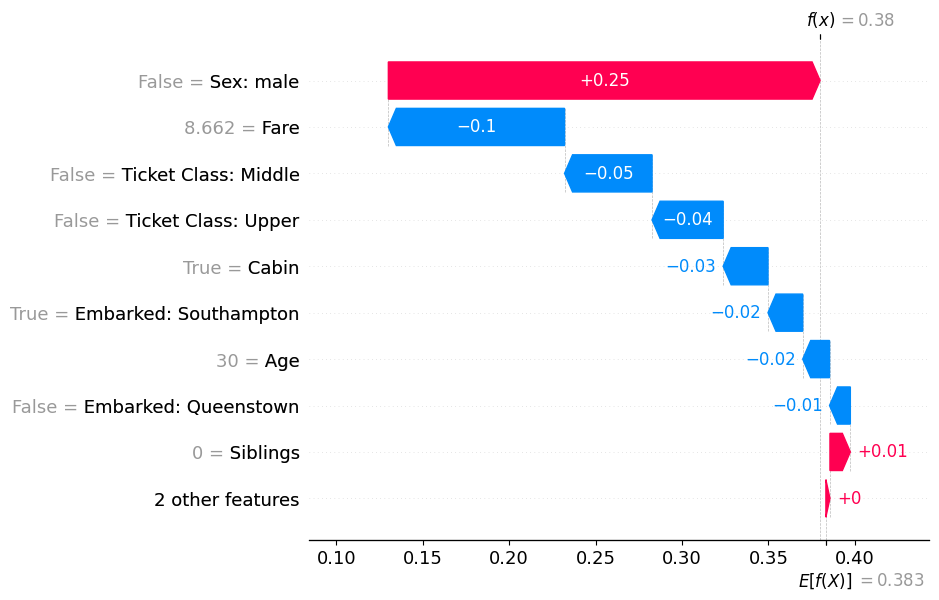

                      contribution  abs_contribution  overall_avg   value
Sex: male                 0.249830          0.249830     0.647587   False
Fare                     -0.101959          0.101959    32.204208  8.6625
Ticket Class: Middle     -0.050638          0.050638     0.206510   False


'Feature --> Sex: male = False, Contribution: 25.0%, Overall Average: 64.8%\nFeature --> Fare = $9, Contribution: -10.2%, Overall Average: $32.2\nFeature --> Ticket Class: Middle = False, Contribution: -5.1%, Overall Average: 20.7%\n\nOutcome: This passenger did not Survive.\n\n'

In [24]:
sample_3 = get_sample(534)
sample_3

In [25]:
explanation_3 = "This passanger did not survive in spite of being a female which improved her chance of survival by 25.0%. It helped that her $9 fare was much lower than the the average fare of $32.2 that everyone else paid. This had a negative contribution of -10.2% to her survival. Her ticket class was 'Middle', which further worsened her chance of survival by -5.1%"

sample_3

'Feature --> Sex: male = False, Contribution: 25.0%, Overall Average: 64.8%\nFeature --> Fare = $9, Contribution: -10.2%, Overall Average: $32.2\nFeature --> Ticket Class: Middle = False, Contribution: -5.1%, Overall Average: 20.7%\n\nOutcome: This passenger did not Survive.\n\n'

#### Sample 4

In [26]:
sample_4 = get_sample(301, False)

                       contribution  abs_contribution  overall_avg  value
Sex: male                 -0.152750          0.152750     0.647587   True
Embarked: Southampton      0.061513          0.061513     0.722783  False
Siblings                   0.030024          0.030024     0.523008      2


In [27]:
sample_4

'Feature --> Sex: male = True, Contribution: -15.3%, Overall Average: 64.8%\nFeature --> Embarked: Southampton = False, Contribution: 6.2%, Overall Average: 72.3%\nFeature --> Siblings = 2, Contribution: 3.0%, Overall Average: 0.5\n\nOutcome: This passenger survived.\n\n'

In [28]:
explanation_4 = "This passanger did survive in spite of being a male which reduced his chance of survival by 15.3%. It helped that he did not embark from Southampton and he was traveling with 2 siblings, which improved his probability of survival by 6.2% and 3.0% respectively."

#### Sample 5

In [29]:
sample_5 = get_sample(756, False)

                     contribution  abs_contribution  overall_avg   value
Sex: male               -0.129434          0.129434     0.647587    True
Fare                    -0.041977          0.041977    32.204208  7.7958
Ticket Class: Upper     -0.023089          0.023089     0.242424   False


In [30]:
sample_5

'Feature --> Sex: male = True, Contribution: -12.9%, Overall Average: 64.8%\nFeature --> Fare = $8, Contribution: -4.2%, Overall Average: $32.2\nFeature --> Ticket Class: Upper = False, Contribution: -2.3%, Overall Average: 24.2%\n\nOutcome: This passenger did not Survive.\n\n'

In [31]:
explanation_5 = "There were several factors that contributed to this passangers demise: being male contributed -12.9%, and having a lowe ticket fare -- only $8 as compared to the average of $32.2 that everyone else paid -- contributed -4.2%. Also, it didn't help that his ticket class was not 'Upper'. This reduced his chances of survival by -2.3%."

#### Sample 6

In [32]:
sample_6 = get_sample(299, False)
sample_6

                     contribution  abs_contribution  overall_avg     value
Sex: male                0.268978          0.268978     0.647587     False
Fare                     0.101691          0.101691    32.204208  247.5208
Ticket Class: Upper      0.091127          0.091127     0.242424      True


'Feature --> Sex: male = False, Contribution: 26.9%, Overall Average: 64.8%\nFeature --> Fare = $248, Contribution: 10.2%, Overall Average: $32.2\nFeature --> Ticket Class: Upper = True, Contribution: 9.1%, Overall Average: 24.2%\n\nOutcome: This passenger survived.\n\n'

In [33]:
explanation_6 = "She survived, largely due to the fact that she was a female. This contributed as much as 26.9% to her survival. She also paid a much higher fare of $248 as compared to $32.2 that everyone else paid on average. The higher fare helped her by 10.2%. Lastly, her ticket class was 'Upper', which worked in her favor by increasing her chance of survival by 9.1%."

#### Sample 7

In [34]:
sample_7 = get_sample(64, False)
sample_7

                     contribution  abs_contribution  overall_avg    value
Sex: male               -0.161338          0.161338     0.647587     True
Ticket Class: Upper      0.056736          0.056736     0.242424     True
Fare                     0.045103          0.045103    32.204208  27.7208


'Feature --> Sex: male = True, Contribution: -16.1%, Overall Average: 64.8%\nFeature --> Ticket Class: Upper = True, Contribution: 5.7%, Overall Average: 24.2%\nFeature --> Fare = $28, Contribution: 4.5%, Overall Average: $32.2\n\nOutcome: This passenger did not Survive.\n\n'

In [35]:
explanation_7 = "This passanger did not survive, mainly due to the fact that he was a male, which reduced his chance of survival by -16.1%. Two other factors, his ticket class (Upper) and low fare ($28), actually improved his chance of survival, by 5.7% and 4.5%, but this was not enough to overcome the negative factors."

#### Sample 8

In [36]:
sample_8 = get_sample(700, False)
sample_8

                     contribution  abs_contribution  overall_avg    value
Sex: male                0.253869          0.253869     0.647587    False
Fare                     0.101930          0.101930    32.204208  227.525
Ticket Class: Upper      0.090677          0.090677     0.242424     True


'Feature --> Sex: male = False, Contribution: 25.4%, Overall Average: 64.8%\nFeature --> Fare = $228, Contribution: 10.2%, Overall Average: $32.2\nFeature --> Ticket Class: Upper = True, Contribution: 9.1%, Overall Average: 24.2%\n\nOutcome: This passenger survived.\n\n'

In [40]:
explanation_8 = "The biggest contributor to this passanger's survial was the fact that she was a female. This increased her chance of survival by as much as 25.4%. Her fare was also higher than the overall average: $228 as compared to $32.2 that everyone else paid on average. The fare further improved her chance of survival by 10.2%. It also helped that her ticket class was 'Upper', which caused a further increase of her chance of survival by 9.1%."

#### Sample 9

In [39]:
sample_9 = get_sample(299, False)
sample_9

                     contribution  abs_contribution  overall_avg     value
Sex: male                0.268978          0.268978     0.647587     False
Fare                     0.101691          0.101691    32.204208  247.5208
Ticket Class: Upper      0.091127          0.091127     0.242424      True


'Feature --> Sex: male = False, Contribution: 26.9%, Overall Average: 64.8%\nFeature --> Fare = $248, Contribution: 10.2%, Overall Average: $32.2\nFeature --> Ticket Class: Upper = True, Contribution: 9.1%, Overall Average: 24.2%\n\nOutcome: This passenger survived.\n\n'

In [41]:
explanation_9 = "This passanger survived mostly because of her gender -- female -- which contributed 26.9% to her survival. Her higher fare ($248 as compared to $32.2 that everyone else paid on average) and her ticket class ('Upper') further contributed positively to her chance of survival by 10.2% and 9.1%, respectively."

#### Sample 10

In [119]:
sample_10 = get_sample(240, False)
sample_10

                       contribution  abs_contribution  overall_avg  value
Sex: male                  0.270100          0.270100     0.647587  False
Ticket Class: Middle      -0.049773          0.049773     0.206510  False
Embarked: Southampton      0.044382          0.044382     0.722783  False


'Feature --> Sex: male = False, Contribution: 27.0%, Overall Average: 64.8%\nFeature --> Ticket Class: Middle = False, Contribution: -5.0%, Overall Average: 20.7%\nFeature --> Embarked: Southampton = False, Contribution: 4.4%, Overall Average: 72.3%\n\nOutcome: This passenger did not Survive.\n\n'

In [120]:
explanation_10 = "In spite of being a female, this passanger did not survive. He gender did contribute positively to her surival, but other factors didn't work in her favor. For example, her ticket class, 'Middle', reduced her chance of survival by -5.0%."

Okay, so now that we have sufficient number of data points, let's proceed to fine-tuning a GPT model.

<a id='llm-prompt'></a>
### Prepare LLM Prompt

First, we will need a system prompt.

In [46]:
system_message = "You can parse tabular data that contains information about various attributes of a passanger who was on the Titanic ship. Each attribute's contribution -- positive or negative -- to the passanger's survival is shown. The data also shows the value of that attribute for this passanger as well as the value across all passangers on the shop. Do not make up any numbers. Use numbers provided in the dataset only and generate an explanation for why this person did or did not survive the crash."

Second, we will loop through all the data points that we have created manually, and add them to `messages` list that will be used for fune-tuning.

In [45]:
samples = [sample_1, sample_2, sample_3, sample_4, sample_5,
          sample_6, sample_7, sample_8, sample_9, sample_10]

explanations = [explanation_1, explanation_2, explanation_3, explanation_4, explanation_5, 
               explanation_6, explanation_7, explanation_8, explanation_9, explanation_10]

In [47]:
messages = []

for sample, expl in zip(samples, explanations):
    messages_list = []

    messages_list.append({'role': 'system',  'content': system_message})
    messages_list.append({'role': 'user', 'content': sample})
    messages_list.append({'role': 'assistant', 'content': expl})

    msg = {"messages": messages_list}
    messages.append(msg)
    
pprint(messages)  

[{'messages': [{'content': 'You can parse tabular data that contains '
                           'information about various attributes of a '
                           'passanger who was on the Titanic ship. Each '
                           "attribute's contribution -- positive or negative "
                           "-- to the passanger's survival is shown. The data "
                           'also shows the value of that attribute for this '
                           'passanger as well as the value across all '
                           'passangers on the shop. Do not make up any '
                           'numbers. Use numbers provided in the dataset only '
                           'and generate an explanation for why this person '
                           'did or did not survive the crash.',
                'role': 'system'},
               {'content': 'Feature --> Sex: male = False, Contribution: '
                           '36.9%, Overall Average: 64.8%\n'
        

We need to upload the file to OpenAI platform (so that it can be used for fine-tuning.) Let's create a local file first.

Note: The OpenAI batch API only supports `.jsonl` (JSON lines) files. 

In [48]:
def write_jsonl(data_list: list, filename: str) -> None:
    with open(filename, "w") as out:
        for ddict in data_list:
            jout = json.dumps(ddict) + "\n"
            out.write(jout)

training_file_name = "../data/titanic_finetuning_samples.jsonl"
write_jsonl(messages, training_file_name)

### Fine-tune LLM

Now it's time to finally connect with OpenAI API.

In [49]:
sys.path.append('../')
load_dotenv('../.env')
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [50]:
client = OpenAI(api_key=OPENAI_API_KEY)

Upload (create) the training dataset to OpenAI. Once uploaded, you will be able to view it at https://platform.openai.com/storage.

In [51]:
upload_file_response = client.files.create(file=open(training_file_name, "rb"), purpose="fine-tune")

In [52]:
upload_file_response

FileObject(id='file-knsBxQam59Dw4AV1ofpg23Ub', bytes=12200, created_at=1719847391, filename='titanic_finetuning_samples.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
We will need the file ID from this response later 

In [53]:
training_file_id = upload_file_response.id
training_file_id

'file-knsBxQam59Dw4AV1ofpg23Ub'

Let's quickly check to make sure that we can connect with OpenAI's chat completion API.

In [54]:
try:
  #Make your OpenAI API request here
  response = client.completions.create(
    prompt="What's up?",
    model="gpt-3.5-turbo-instruct"
  )
except openai.APIError as e:
  #Handle API error here, e.g. retry or log
  print(f"OpenAI API returned an API Error: {e}")
  pass
except openai.APIConnectionError as e:
  #Handle connection error here
  print(f"Failed to connect to OpenAI API: {e}")
  pass
except openai.RateLimitError as e:
  #Handle rate limit error (we recommend using exponential backoff)
  print(f"OpenAI API request exceeded rate limit: {e}")
  pass

pprint(response.choices[0].text)

"\n\nThere are many things that could be going on, so it's hard to"


Yes, we got some response, so we're good! If you caught an exception here then something is wrong.

Now we are ready to fine-tune the model

In [57]:
response = client.fine_tuning.jobs.create(training_file=training_file_id,
                                          model="gpt-3.5-turbo")

In [58]:
response

FineTuningJob(id='ftjob-UbwdR87ErSMiOfYvC57fSTWT', created_at=1719847578, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-YzAUwDK6A4v8MmfykJSmk3c6', result_files=[], seed=1544328055, status='validating_files', trained_tokens=None, training_file='file-knsBxQam59Dw4AV1ofpg23Ub', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [67]:
response.status

'validating_files'

This should take about ten minutes. You can view the progress on https://platform.openai.com/finetune. Once the job completes, you should see something like this:

<img src='../img/openai_fine-tuning_status_complete.png' width=400>

Let's grab the model ID from the response. We will need to use this for inference.

In [76]:
job_id = response.id
job_id

'ftjob-UbwdR87ErSMiOfYvC57fSTWT'

In [79]:
response = client.fine_tuning.jobs.retrieve(job_id)
response

FineTuningJob(id='ftjob-UbwdR87ErSMiOfYvC57fSTWT', created_at=1719847578, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:derive::9gDKMH5F', finished_at=1719848033, hyperparameters=Hyperparameters(n_epochs=10, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-YzAUwDK6A4v8MmfykJSmk3c6', result_files=['file-jyLTChcC1jFlpcIwtO7SUBUy'], seed=1544328055, status='succeeded', trained_tokens=26610, training_file='file-knsBxQam59Dw4AV1ofpg23Ub', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [82]:
model_id = response.fine_tuned_model
model_id

'ft:gpt-3.5-turbo-0125:derive::9gDKMH5F'

### Make Inference

Take a sample passenger and create a test data point.

In [83]:
sample_test = get_sample(200, False)
sample_test

           contribution  abs_contribution  overall_avg value
Sex: male     -0.123660          0.123660     0.647587  True
Fare          -0.034322          0.034322    32.204208   9.5
Cabin         -0.027327          0.027327     0.771044  True


'Feature --> Sex: male = True, Contribution: -12.4%, Overall Average: 64.8%\nFeature --> Fare = $10, Contribution: -3.4%, Overall Average: $32.2\nFeature --> Cabin = True, Contribution: -2.7%, Overall Average: 77.1%\n\nOutcome: This passenger did not Survive.\n\n'

In [85]:
test_message = []

test_message.append({"role": "system", "content": system_message})
test_message.append({"role": "user", "content": sample_test})

print(test_message)

[{'role': 'system', 'content': "You can parse tabular data that contains information about various attributes of a passanger who was on the Titanic ship. Each attribute's contribution -- positive or negative -- to the passanger's survival is shown. The data also shows the value of that attribute for this passanger as well as the value across all passangers on the shop. Do not make up any numbers. Use numbers provided in the dataset only and generate an explanation for why this person did or did not survive the crash."}, {'role': 'user', 'content': 'Feature --> Sex: male = True, Contribution: -12.4%, Overall Average: 64.8%\nFeature --> Fare = $10, Contribution: -3.4%, Overall Average: $32.2\nFeature --> Cabin = True, Contribution: -2.7%, Overall Average: 77.1%\n\nOutcome: This passenger did not Survive.\n\n'}]


Notice that we are not providing the explanation this time. We would like the trained model to provide the explanation for why this passenger did not survive.

In [86]:
response = client.chat.completions.create(model=model_id,
                                          messages=test_message,
                                          temperature=0,
                                          max_tokens=500)

response

ChatCompletion(id='chatcmpl-9gDhbgUHk1UdzypEIX0eGVzGsdpPX', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='This passanger did not survive, mainly driven by the fact that he was a male, which reduced his chance of survival by -12.4%. He also paid a lower fare -- only $10 as compared to the average of $32.2 that everyone else paid. The low fare further reduced his chance of survival by -3.4%. He stayed in a cabin, just like 77.1% of all passengers, which reduced his chance of survival a little bit by -2.7%.', role='assistant', function_call=None, tool_calls=None))], created=1719849475, model='ft:gpt-3.5-turbo-0125:derive::9gDKMH5F', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=102, prompt_tokens=183, total_tokens=285))

Great! It's provided the explanation, but it's buried in the `ChatCompletion()` object. Let's dig it out.

In [97]:
response.choices[0].message.content

'This passanger did not survive, mainly driven by the fact that he was a male, which reduced his chance of survival by -12.4%. He also paid a lower fare -- only $10 as compared to the average of $32.2 that everyone else paid. The low fare further reduced his chance of survival by -3.4%. He stayed in a cabin, just like 77.1% of all passengers, which reduced his chance of survival a little bit by -2.7%.'

This makes sense. Let's compare it with the data.

In [98]:
sample_test

'Feature --> Sex: male = True, Contribution: -12.4%, Overall Average: 64.8%\nFeature --> Fare = $10, Contribution: -3.4%, Overall Average: $32.2\nFeature --> Cabin = True, Contribution: -2.7%, Overall Average: 77.1%\n\nOutcome: This passenger did not Survive.\n\n'

Yay! The explanation aligns with the Shapley values and the overall means. As instructed, the model did not make up any data; all percentages etc. are extracted directly from the prompt.

### Build a Gradio UI

We will not create a simple Gradio app to display these results. We will give the user an ability to pick any passenger.

In [101]:
# the index contains the full names of passengers
indices = df.index.tolist()
indices[:5]

['Braund, Mr. Owen Harris',
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
 'Heikkinen, Miss. Laina',
 'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
 'Allen, Mr. William Henry']

In [116]:
def get_gpt_response(index_label):
    '''Use the trained model to convert the Shapley output into plain English summary
    '''
    message = []
    message.append({"role": "system", "content": system_message})

    sample_id_location = df.index.get_loc(index_label)
    prompt = get_sample(sample_id_location, False)
    
    message.append({"role": "user", "content": prompt})

    response = client.chat.completions.create(model=model_id,
                                              messages=message,
                                              temperature=0,
                                              max_tokens=500)
    return response.choices[0].message.content

def shap_analysis(index_label):
    '''For the given passenger, perform Shapley analysis and generate the waterfall chart
    '''
    sample_id_location = df.index.get_loc(index_label)

    _shap_values = shap_values[sample_id_location, :, 1]

    fig, ax = plt.subplots(figsize=(10, 10))
    shap.plots.waterfall(_shap_values, max_display=5)
    #plt.title('Shapley Values')
    plt.tight_layout()

    tmp_file = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
    plt.savefig(tmp_file.name)
    plt.close(fig)

    return tmp_file.name

def combined_interface(index_label):
    '''Shapley analysis + summarization by LLM
    '''
    gpt_response = get_gpt_response(index_label)
    shap_fig = shap_analysis(index_label)
    
    return gpt_response, shap_fig

with gr.Blocks() as titanic:
    gr.Markdown('# Titanic Passenger Survival Analysis')
    with gr.Row():
        index_label = gr.Dropdown(choices=indices, label='Select a passanger:')
    with gr.Row():
        submit_button = gr.Button('Submit')
    with gr.Row():
        gpt_output = gr.Textbox(label='LLM Explanation:')
    with gr.Row():
        shap_output = gr.Image(type="filepath", label="Feature Contributions")
    
    submit_button.click(combined_interface, inputs=index_label, outputs=[gpt_output, shap_output])

titanic.launch()

Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.
